[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://drive.google.com/open?id=1yz04kc2zstt1SlyamzuyWF_4DjPQE0Ta)

# Техническая часть

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

train_text_dwld = drive.CreateFile({'id':'1I9vf6z80Pjs4oou2WJE728s4HpiFR1qm'})
train_text_dwld.GetContentFile('train.ft.txt.bz2')

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

import bz2
import re

In [0]:
def get_labels_and_texts(file):
    labels = []
    texts = []
    count = 0
    for line in bz2.BZ2File(file):
        x = line.decode("utf-8")
        if len(x[10:].strip().split(' ')) < 100:
            texts.append(x[10:].strip())
            labels.append(int(x[9]) - 1)
            count +=1

        if count > 500000:
            return labels, texts

In [0]:
def preprocess_text(text):
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)
    text = re.sub(r'https?:/\/\S+', ' ', text)
    return text.lower()

# Что там с данными

In [0]:
train_labels, train_texts = get_labels_and_texts('train.ft.txt.bz2')

In [0]:
train_texts = [preprocess_text(t) for t in train_texts]
assert len(train_labels) == len(train_texts)

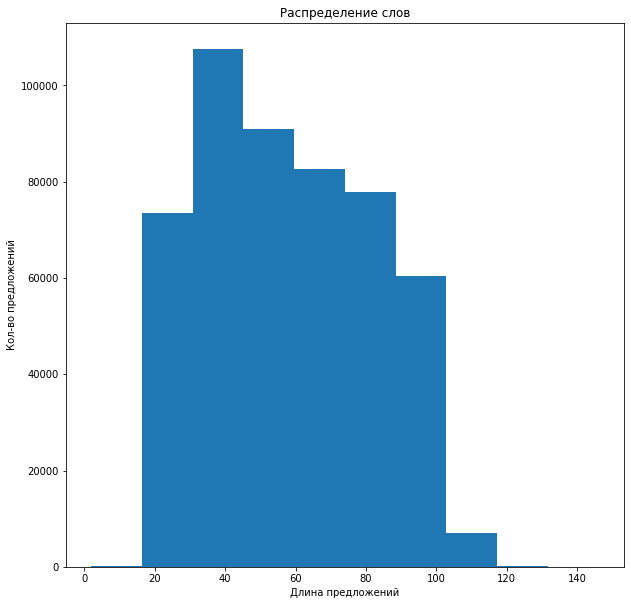

In [7]:
text = [i.split(' ') for i in train_texts]
sentence_lengths = [len(tokens) for tokens in text]
# порисуем
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Длина предложений')
plt.ylabel('Кол-во предложений')
plt.title('Распределение слов')
plt.hist(sentence_lengths)
plt.show()

In [8]:
dt = pd.DataFrame(list(zip(train_labels, train_texts)), columns =['labels', 'texts'])
dt.head()

,labels,texts
0,1,stuning even for the non gamer this sound trac...
1,1,the best soundtrack ever to anything i m readi...
2,1,remember pull your jaw off the floor after hea...
3,1,whispers of the wicked saints this was a easy ...
4,0,the worst a complete waste of time typographic...


In [9]:
dt['labels'].value_counts()

1    260585
0    239416
Name: labels, dtype: int64

Классы сбалансированы, а это значит, можно и accuracy использовать для оценки точности алгоритма. 

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train_texts, train_labels,
                                                    test_size=0.3, random_state=40)

# Классика

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

## BaseLine: Tf-Idf + LogReg

### TF-IDF

**TF-IDF** - это term frequency-inverse document frequency или, ежели на великом и могучем, частотность терминов-обратная частотность документов. Ага, лично мне было очень трудно просто принять это название. 

Если возникает вопрос, зачем он нужен, то ответ прост - компьютер не понимает слова, а понимает только цифры. Надо из слов сделать цифры. Вся идея, это уже потом захотели еще и контекст сохранять, но об этом позже. 

Вообще, простыми словами это простой и удобный способ оценить важность термина для какого-либо документа относительно всех остальных документов. Принцип такой — если слово встречается в каком-либо документе часто, при этом встречаясь редко во всех остальных документах — это слово имеет большую значимость для того самого документа.

TF-IDF, как бы глупо не звучало, состоит из TF и IDF, точнее их произведение. А теперь подробнее про каждый элемент:

**TF слова а** - (Количество раз, когда слово а встретился в тексте / количество всех слов в тексте)

**IDF слова а** - Log(Общее количество документов / Количество документов, в которых встречается слово а) 

Считается как-нибудь так:
$$\text{idf}(t) = \text{log}\frac{1 + n_a}{1 + n_{a(t)}} + 1$$
где $n_a$ - число всех документов, а $n_{a(t)}$ - число документов со словом `a`.


А потом перемножаем и оп у нас уже есть мера важности слова. 

In [0]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer(analyzer = "word")

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

In [0]:
X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [20]:
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)
pred = lr.predict(X_test_tfidf)

print('Результат (f-мера): {}'.format(f1_score(y_test, pred)))

Результат (f-мера): 0.9147515547698687


А можно так:

In [21]:
vectorizer = TfidfVectorizer(analyzer='word')
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
]) 

model.fit(X_train, y_train)
pred = model.predict(X_test)
print('accuracy: ', accuracy_score(y_test, pred))

accuracy:  0.9106272624849168


## Добавим n-gramm

Разберемся, что такое n-gramm. Например, слово `кружка` мы можем представить в виде такой последовательности триграмм:

`##к #кр кру руж ужк жка ка# а##`

In [22]:
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
]) 

model.fit(X_train, y_train)
pred = model.predict(X_test)
print('accuracy: ', accuracy_score(y_test, pred))

accuracy:  0.9278271478190145


## TODO: W2V + tf-idf

## Предсказание

In [0]:
def user_predict(text, model=model):
    predict = model.predict([text])
    predict_pr = model.predict_proba([text])
    if predict == 0:
        return ('Это негативное высказывания с вероятностью: {:.2f}%'.format(predict_pr[0][0]*100))
    if predict == 1:
        return ('Это положительное высказывания с вероятностью: {:.2f}%'.format(predict_pr[0][1]*100))
    
    return predict

In [32]:
user_predict('ah shit here we go again')

'Это негативное высказывания с вероятностью: 58.04%'

In [33]:
user_predict('shut up and take my money')

'Это негативное высказывания с вероятностью: 90.28%'

# Диип Лёрнинг

![хехехе](https://raw.githubusercontent.com/DanilDmitriev1999/Sentiment_Analysis_from-to/master/img/meme.png)

Люблю эту картинку

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from collections import Counter

In [30]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if device == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))
is_cuda = torch.cuda.is_available()
print("Cuda Status on system is {}".format(is_cuda))

Tesla P4
Cuda Status on system is True


In [0]:
words = Counter() 
for i, sentence in enumerate(text):
    text[i] = []
    for word in sentence:
        words.update([word]) 
        text[i].append(word)


In [0]:
# Удаление слов, которые появляются меньше 5 раз
words = {k:v for k,v in words.items() if v>5}
# Сортировка слов по количеству появлений, причем наиболее распространенным словом является первое
words = sorted(words, key=words.get, reverse=True)
# Добавление PAD-ов
words = ['_PAD','_UNK'] + words
# Словари для хранения слов в индексных сопоставлениях и наоборот
word2idx = {o:i for i,o in enumerate(words)}
idx2word = {i:o for i,o in enumerate(words)}

In [0]:
for i, sentence in enumerate(text):
    # Поиск словаря сопоставления и присвоение индекса соответствующим словам
    text[i] = [word2idx[word] if word in word2idx else 0 for word in sentence]

In [0]:
# Определение функции, которая либо сокращает предложения, либо дополняет предложения с 0 до фиксированной длины
def pad_input(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [0]:
seq_len = 200 #Длина, до которой предложения будут дополнены / сокращены

train_sentences = pad_input(text, seq_len)
train_labels = np.array(train_labels)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train_sentences, train_labels,
                                                    test_size=0.3, random_state=40)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    test_size=0.1, random_state=40)

In [0]:
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

batch_size = 128

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True, )
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

# del X_train, y_train, X_val, y_val, X_test, y_test

In [0]:
dataiter = iter(train_loader)

In [42]:
sample_x, sample_y = dataiter.next()

print(sample_x.shape, sample_y.shape)

torch.Size([128, 200]) torch.Size([128])


In [43]:
dataiter_val = iter(val_loader)
sample_x, sample_y = dataiter_val.next()

print(sample_x.shape, sample_y.shape)

torch.Size([128, 200]) torch.Size([128])


## RNN

![rnn](https://raw.githubusercontent.com/DanilDmitriev1999/Sentiment_Analysis_from-to/master/img/rnn1.png)

In [0]:
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        self.lin = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, text):
        batch_size = text.size(0)
        text = text.long()
        embedded = self.embedding(text)
        
        output, hidden = self.rnn(embedded)
        output = output.contiguous()
        
        output = self.lin(output)
        output = self.sigmoid(output)
        
        output = output.view(batch_size, -1)
        output = output[:,-1]
        return output

In [49]:
INPUT_DIM = len(word2idx) + 1
EMBEDDING_DIM = 200
HIDDEN_DIM = 256
OUTPUT_DIM = 1

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
model

RNN(
  (embedding): Embedding(51170, 200)
  (rnn): RNN(200, 256)
  (lin): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [50]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Модель имеет {count_parameters(model):,} параметров')

Модель имеет 10,351,505 параметров


In [0]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

#model = model.to(device)
#criterion = criterion.to(device)

In [52]:
epochs = 2
counter = 0
print_every = 100
clip = 5
valid_loss_min = np.Inf

model.train()
for i in range(epochs):
    for inputs, labels in train_loader:
        counter += 1
        inputs, labels = inputs, labels
        model.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        if counter%print_every == 0:
            val_losses = []
            model.eval()
            for inp, lab in val_loader:
                inp, lab = inp, lab
                out = model(inp)
                #print(out.shape)
                val_loss = criterion(out, lab.float())
                val_losses.append(val_loss.item())
                
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Epoch: 1/2... Step: 100... Loss: 0.707362... Val Loss: 0.693782
Epoch: 1/2... Step: 200... Loss: 0.691654... Val Loss: 0.692219
Epoch: 1/2... Step: 300... Loss: 0.686343... Val Loss: 0.691815
Epoch: 1/2... Step: 400... Loss: 0.679715... Val Loss: 0.693115
Epoch: 1/2... Step: 500... Loss: 0.693023... Val Loss: 0.691440
Epoch: 1/2... Step: 600... Loss: 0.699584... Val Loss: 0.691679
Epoch: 1/2... Step: 700... Loss: 0.704016... Val Loss: 0.692860
Epoch: 1/2... Step: 800... Loss: 0.697955... Val Loss: 0.698858
Epoch: 1/2... Step: 900... Loss: 0.714311... Val Loss: 0.698148


KeyboardInterrupt: ignored

Оч долго обучается, достаточно. Loss стремный

In [0]:
test_losses = []
num_correct = 0

model.eval()
for inputs, labels in test_loader:
    output = model(inputs)
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    pred = torch.round(output.squeeze()) #rounds the output to 0/1
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

In [54]:
print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}%".format(test_acc*100))

Test loss: 0.692
Test accuracy: 52.490%


Ну, тут чет не весело: 52% точности. Очень не исключено, что я это я где-то промохнулся, хотя я бы не стал доверять RNN, слишком уж они стремные.  

## LSTM

In [0]:
class SentimentNet(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(SentimentNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            dropout=drop_prob, batch_first=True,
                            bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim*2, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim*2)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers * 2, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers * 2, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [56]:
vocab_size = len(word2idx) + 1
output_size = 1
embedding_dim = 200
hidden_dim = 256
n_layers = 2

model = SentimentNet(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model.to(device)
print(model)
print(f'Модель имеет {count_parameters(model):,} параметров')

SentimentNet(
  (embedding): Embedding(51170, 200)
  (lstm): LSTM(200, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Модель имеет 12,749,457 параметров


In [0]:
lr=0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [58]:
epochs = 2
counter = 0
print_every = 500
clip = 5
valid_loss_min = np.Inf

model.train()
for i in range(epochs):
    h = model.init_hidden(batch_size)
    
    for inputs, labels in train_loader:
        counter += 1
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output, h = model(inputs, h)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        if counter%print_every == 0:
            val_h = model.init_hidden(batch_size)
            val_losses = []
            model.eval()
            for inp, lab in val_loader:
                val_h = tuple([each.data for each in val_h])
                inp, lab = inp.to(device), lab.to(device)
                out, val_h = model(inp, val_h)
                val_loss = criterion(out.squeeze(), lab.float())
                val_losses.append(val_loss.item())
                
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Epoch: 1/2... Step: 500... Loss: 0.266939... Val Loss: 0.319916
Epoch: 1/2... Step: 1000... Loss: 0.179538... Val Loss: 0.232975
Epoch: 1/2... Step: 1500... Loss: 0.129894... Val Loss: 0.200912
Epoch: 1/2... Step: 2000... Loss: 0.152333... Val Loss: 0.187183
Epoch: 2/2... Step: 2500... Loss: 0.129379... Val Loss: 0.175909
Epoch: 2/2... Step: 3000... Loss: 0.176354... Val Loss: 0.172896
Epoch: 2/2... Step: 3500... Loss: 0.163189... Val Loss: 0.173738
Epoch: 2/2... Step: 4000... Loss: 0.112212... Val Loss: 0.166080
Epoch: 2/2... Step: 4500... Loss: 0.106493... Val Loss: 0.165175


In [59]:
test_losses = []
num_correct = 0
h = model.init_hidden(batch_size)

model.eval()
for inputs, labels in test_loader:
    h = tuple([each.data for each in h])
    inputs, labels = inputs.to(device), labels.to(device)
    output, h = model(inputs, h)
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    pred = torch.round(output.squeeze()) #rounds the output to 0/1
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)
        
print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}%".format(test_acc*100))

Test loss: 0.166
Test accuracy: 93.392%


Уже лучше